# Analyzing Topical Model of Facebook's Topics aiming towards Users. 

In [26]:
from __future__ import absolute_import, division, print_function
# for word vec
import gensim
from gensim.models import Word2Vec as w2v
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from sklearn.feature_extraction.text import TfidfVectorizer

import codecs
import glob
import multiprocessing
import os
import nltk
import pprint
import re
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools

from ast import literal_eval # to import the column texts as list
from langdetect import detect

In [27]:
def lang_detect(s):
    try:
        return detect(s)
    except:
        return np.nan

# split into words
def get_words(raw):
    """
    :raw: text that has not been cleaned yet
    output: Stemmed Tokens
    
    ToDo: language as input
    """
    from nltk.tokenize import word_tokenize
    import string
    from nltk.corpus import stopwords
    from nltk.stem.porter import PorterStemmer
    tokens = word_tokenize(raw)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('spanish'))
    words = [w for w in words if not w in stop_words]
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in words]
    return stemmed

def get_topic_distribution(lda_model, raw_input, dictionary):
    """Return a vecor of topical distribution of each document or text. 
    :param lda_model: the output of the function gensim.models.ldamodel.LdaModel
    :param raw_imput: raw chinese policy text or doc
    :param dictionary: the output of corpora.Dictionary() function which is the vocab.
    """
    from pandas import DataFrame
    other_texts = [ # needs tokenized
        get_words(raw_input)
    ]
    #dictionary = Dictionary(sentences)
    other_corpus = [dictionary.doc2bow(text) for text in other_texts]
    unseen_doc = other_corpus[0]
    vector = lda_model[unseen_doc][0]
    return(DataFrame.from_records(vector)[1])

# Does politcal advertisements have an impact on the US November election? 
## Testing on random sample of Facebook users:
- Only English 
- From October to December
- Testing the US election in November vs FB ads political influence

In [39]:
import random
df = pd.read_csv('~/Code/tracking-exposed/experiments-data/eu19/dataset_eu19/user_a.csv', index_col=0)
df.texts = df.texts.apply(literal_eval)
random.seed(10)
df['concatenatedText'] = df['texts'].apply(''.join)
df['images'] = df['images'].apply(literal_eval)
df['images.count'] = df.images.apply(lambda x: x['count'])
df['concatLanguage'] = df.concatenatedText.apply(lang_detect) # Do we need it?
RANDOM_SAMPLE = df.sample(1000)[['ANGRY', 'HAHA', 'LIKE', 'LOVE', 'SAD', 'WOW', 'displaySource',
'fblinktype', 'id', 'images.count', 'impressionOrder', 'impressionTime',
'nature', 'permaLink', 'postId', 'publicationTime', 'source',
'sourceLink', 'timeline', 'user', 'concatenatedText', 'concatLanguage']] # just taking a random sample of the population

In [40]:
RANDOM_SAMPLE.columns

Index(['ANGRY', 'HAHA', 'LIKE', 'LOVE', 'SAD', 'WOW', 'displaySource',
       'fblinktype', 'id', 'images.count', 'impressionOrder', 'impressionTime',
       'nature', 'permaLink', 'postId', 'publicationTime', 'source',
       'sourceLink', 'timeline', 'user', 'concatenatedText', 'concatLanguage'],
      dtype='object')

In [43]:
set(RANDOM_SAMPLE.concatLanguage)

{'ca', 'de', 'en', 'es', 'et', 'fr', 'it', nan}

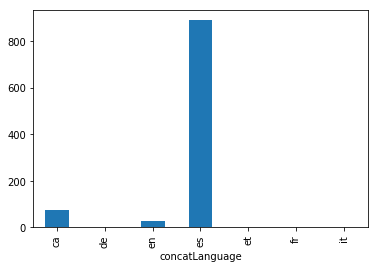

In [44]:
RANDOM_SAMPLE.concatLanguage.groupby([RANDOM_SAMPLE.concatLanguage]).count().plot(kind='bar')

In [45]:
# Filter out post in languages other then our main language
RANDOM_SAMPLE = RANDOM_SAMPLE[(RANDOM_SAMPLE.concatLanguage == 'ca') | 
                               (RANDOM_SAMPLE.concatLanguage == 'es')]

In [46]:
RANDOM_SAMPLE['publicationTime'] = pd.to_datetime(RANDOM_SAMPLE['publicationTime']).dt.date
RANDOM_SAMPLE = RANDOM_SAMPLE.sort_values(by='publicationTime')
RANDOM_SAMPLE.head()

,ANGRY,HAHA,LIKE,LOVE,SAD,WOW,displaySource,fblinktype,id,images.count,...,nature,permaLink,postId,publicationTime,source,sourceLink,timeline,user,concatenatedText,concatLanguage
5525,0.0,2.0,180.0,9.0,0.0,0.0,Dental Catalunya,NaN,c216d0b8490a19f7687b8b34a4b9f7e7e3d77210,1,...,sponsored,NaN,1991080450931985,2018-01-11,Dental Catalunya,https://www.facebook.com/DentalCatalunya/,spaghetti-pepper-manicotti,rosemary-ceviche-meringue,La clínica dental a prop teu. Seguiment integr...,ca
1277,0.0,2.0,184.0,9.0,0.0,0.0,Dental Catalunya,NaN,463c51fa475878a09b177433c3ab1e6913b2e965,1,...,sponsored,/ads/about,1991080450931985,2018-01-11,Dental Catalunya,https://www.facebook.com/DentalCatalunya/,kebab-cinnamon-cucumber,rosemary-ceviche-meringue,La clínica dental a prop teu. Seguiment integr...,ca
2726,0.0,15.0,144.0,18.0,0.0,0.0,Huel,NaN,750831f2ad66569aff944b6de4fc44bb23059426,1,...,sponsored,/ads/about,571921516608020,2018-12-12,Huel,https://www.facebook.com/huelglobal/,shawarma-pasta-taco,rosemary-ceviche-meringue,"Sin preparación, sin cocinar. Huel es una comi...",es
7948,0.0,9.0,193.0,32.0,0.0,0.0,Cursa Nocturna Sport Ciutat de L'Hospitalet,NaN,1ff91b90929297e54d124af2f500084a84c1cbff,1,...,sponsored,/ads/about,2094374267349884,2019-03-11,Cursa Nocturna Sport Ciutat de L'Hospitalet,https://www.facebook.com/cursanocturna/,pie-manicotti-coffee,rosemary-ceviche-meringue,¿Quieres vivir una gran fiesta deportiva? Te e...,ca
4926,0.0,0.0,3.0,0.0,0.0,0.0,La Royale,NaN,3d5e6c4258b71819f24fc0dfe2c25d05108c01a7,1,...,sponsored,/ads/about,2554434577905372,2019-03-14,La Royale,https://www.facebook.com/restaurantelaroyale/,souffle-sandwich-jelly,rosemary-ceviche-meringue,¡Pide tu hamburguesa! Ya puedes pedir La Royal...,es


In [47]:
# break into tokens for each sentence
import time
start = time.time()
sent = RANDOM_SAMPLE.concatenatedText

sentences = []
for i in sent:
    sentences.append(get_words(i))
end = time.time()
print(end-start, 'seconds')

2.835468053817749 seconds


In [49]:
import pyLDAvis.sklearn
import gensim
import os
import dill
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
from gensim.models import Word2Vec as w2v
import time

# Create Dictionary
start = time.time()
id2word = corpora.Dictionary(sentences)
dictionary = Dictionary(sentences)
# Create Corpus
texts = sentences

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True,
                                           minimum_probability=0.0)



pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

In [50]:
pyLDAvis.display(vis)
#pyLDAvis.show(vis)

In [51]:
lda_model.print_topics()

[(0,
  '0.008*"the" + 0.005*"do" + 0.004*"i" + 0.004*"campaña" + 0.004*"debat" + 0.003*"per" + 0.003*"of" + 0.003*"meno" + 0.003*"hora" + 0.003*"elector"'),
 (1,
  '0.010*"debat" + 0.010*"candidato" + 0.009*"sánchez" + 0.007*"pp" + 0.007*"ciudadano" + 0.007*"podemo" + 0.006*"casado" + 0.006*"pedro" + 0.006*"psoe" + 0.005*"gobierno"'),
 (2,
  '0.008*"año" + 0.005*"pp" + 0.004*"tra" + 0.004*"derecha" + 0.004*"mujer" + 0.004*"barcelona" + 0.003*"toledo" + 0.003*"tre" + 0.003*"ortega" + 0.003*"madrid"')]

## Merge the original dataset with the Topical Distribution spread 

In [52]:
import time
start = time.time()
buckets = []
for i in RANDOM_SAMPLE.concatenatedText:
    buckets.append(get_topic_distribution(lda_model,i,dictionary))
groups= []
for i in range(0,len(buckets)):
    groups.append(pd.Series.to_frame((buckets[i])).T)

groups = pd.concat(groups).reset_index()
DATA =  pd.concat([RANDOM_SAMPLE.reset_index(drop=True), groups],axis=1).reset_index(drop=True)
end = time.time()
print(end-start)
import dill
dill.dump_session('FBenv.db')
#dill.load_session('FBenv.db')

6.612600088119507


In [53]:
DATA.columns

Index([           'ANGRY',             'HAHA',             'LIKE',
                   'LOVE',              'SAD',              'WOW',
          'displaySource',       'fblinktype',               'id',
           'images.count',  'impressionOrder',   'impressionTime',
                 'nature',        'permaLink',           'postId',
        'publicationTime',           'source',       'sourceLink',
               'timeline',             'user', 'concatenatedText',
         'concatLanguage',            'index',                  0,
                        1,                  2],
      dtype='object')

In [15]:
DATA.columns = [           'ANGRY',             'HAHA',             'LIKE',
                   'LOVE',              'SAD',              'WOW',
          'displaySource',       'fblinktype',               'id',
           'images.count',  'impressionOrder',   'impressionTime',
                 'nature',        'permaLink',           'postId',
        'publicationTime',           'source',       'sourceLink',
               'timeline',             'user', 'concatenatedText',
         'concatLanguage',            'index',                  'Politics',
                        'Advertisement',                  'Other']

In [16]:
DATA.columns

Index(['ANGRY', 'HAHA', 'LIKE', 'LOVE', 'SAD', 'WOW', 'displaySource',
       'fblinktype', 'id', 'images.count', 'impressionOrder', 'impressionTime',
       'nature', 'permaLink', 'postId', 'publicationTime', 'source',
       'sourceLink', 'timeline', 'user', 'concatenatedText', 'concatLanguage',
       'index', 'Politics', 'Advertisement', 'Other'],
      dtype='object')

In [17]:
ORGANIC = DATA[DATA.nature == 'organic']
SPONSOR = DATA[DATA.nature == 'sponsored']

In [18]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import pandas as pd
import math
import math
from bubbly.bubbly import add_slider_steps
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
from plotly import tools
import plotly.figure_factory as ff 
import warnings
warnings.filterwarnings('ignore')
import os

#ORGANIC['publicationTime']=pd.to_datetime(ORGANIC['publicationTime']).dt.date
EX = pd.DataFrame(ORGANIC.groupby('publicationTime')[['Politics','Advertisement','Other']].mean()).reset_index(inplace=False)

x= EX.publicationTime

trace1 = dict(
    x= x,
    y= EX['Advertisement'],
    name='Advertisement',
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5),
              #color='rgb(131, 90, 241)'),
    stackgroup='one'
)
trace2 = dict(
    x= x,
    y= EX['Politics'],
    name='Politics',
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5),
              #color='rgb(111, 231, 219)'),
    stackgroup='one'
)
trace3 = dict(
    x= x,
    y= EX['Other'],
    name='Other',
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5),
              #color='rgb(184, 247, 212)'),
    stackgroup='one')


data = [trace1, trace2, trace3]

layout = go.Layout(
    
    legend=dict(x=0, y=-.13,
       orientation="h")
)



# Topical Distribution Spread from Organic Posts Before and After the Election

In [177]:
fig = go.Figure(data=data, layout=layout)
iplot(fig) 

In [178]:

EX = pd.DataFrame(SPONSOR.groupby('publicationTime')[['Politics','Advertisement','Other']].mean()).reset_index(inplace=False)

x= EX.publicationTime

trace1 = dict(
    x= x,
    y= EX['Advertisement'],
    name='Sales Ad',
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5),
              #color='rgb(131, 90, 241)'),
    stackgroup='one'
)
trace2 = dict(
    x= x,
    y= EX['Politics'],
    name='Political Ad',
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5),
              #color='rgb(111, 231, 219)'),
    stackgroup='one'
)
trace3 = dict(
    x= x,
    y= EX['Other'],
    name='Other Ad',
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5),
              #color='rgb(184, 247, 212)'),
    stackgroup='one')


data = [trace1, trace2, trace3]

layout = go.Layout(
    
    legend=dict(x=0, y=-.13,
       orientation="h")
)



# Sponsored Posts Topical Spread Before and After the Election

In [179]:
fig = go.Figure(data=data, layout=layout)
iplot(fig) 

# How much does each User's gets exposed to these Political Advertisements? 
- Study case: pick user with ID "churros-collards-crisp" because he or she has the most impressions

In [180]:
df.user.value_counts() # We will now ananlyze the User's exposure to these Politcal, Advertisements

rosemary-ceviche-meringue    10000
Name: user, dtype: int64

In [183]:
USER = df[df['user']=='rosemary-ceviche-meringue']
USER['publicationTime'] = pd.to_datetime(USER['publicationTime']).dt.date
USER = USER.sort_values(by='publicationTime')

sent = USER.concatenatedText
sentences = []
for i in sent:
    sentences.append(get_words(i))

id2word = corpora.Dictionary(sentences)
dictionary = Dictionary(sentences)
# Create Corpus
texts = sentences

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True,
                                           minimum_probability=0.0)
lda_model.print_topics()

[(0,
  '0.011*"año" + 0.009*"mujer" + 0.005*"cuatro" + 0.005*"toledo" + 0.005*"ser" + 0.004*"álvarez" + 0.004*"va" + 0.004*"piso" + 0.004*"tan" + 0.004*"vida"'),
 (1,
  '0.012*"debat" + 0.011*"pp" + 0.009*"candidato" + 0.009*"partido" + 0.008*"sánchez" + 0.007*"casado" + 0.006*"gobierno" + 0.006*"vox" + 0.006*"podemo" + 0.006*"rivera"'),
 (2,
  '0.009*"año" + 0.008*"cambio" + 0.007*"cada" + 0.006*"meno" + 0.005*"día" + 0.005*"mayor" + 0.005*"tre" + 0.004*"muerto" + 0.004*"domingo" + 0.003*"hace"')]

In [184]:
buckets = []
for i in USER.concatenatedText:
    buckets.append(get_topic_distribution(lda_model,i,dictionary))
groups= []
for i in range(0,len(buckets)):
    groups.append(pd.Series.to_frame((buckets[i])).T)

groups = pd.concat(groups).reset_index()
USER_DATA =  pd.concat([USER.reset_index(drop=True), groups],axis=1).reset_index(drop=True)


In [186]:
USER_DATA.columns

Index([           'ANGRY',             'HAHA',             'LIKE',
                   'LOVE',              'SAD',              'WOW',
          'displaySource',       'fblinktype',               'id',
                 'images',  'impressionOrder',   'impressionTime',
                 'nature',        'opengraph',        'permaLink',
                 'postId',  'publicationTime',    'semanticCount',
             'semanticId',           'source',       'sourceLink',
                  'texts',         'textsize',         'timeline',
                   'user',    'videoautoplay', 'concatenatedText',
           'images.count',   'concatLanguage',            'index',
                        0,                  1,                  2],
      dtype='object')

In [192]:
USER_DATA.columns = [           'ANGRY',             'HAHA',             'LIKE',
                   'LOVE',              'SAD',              'WOW',
          'displaySource',       'fblinktype',               'id',
                 'images',  'impressionOrder',   'impressionTime',
                 'nature',        'opengraph',        'permaLink',
                 'postId',  'publicationTime',    'semanticCount',
             'semanticId',           'source',       'sourceLink',
                  'texts',         'textsize',         'timeline',
                   'user',    'videoautoplay', 'concatenatedText',
           'images.count',   'concatLanguage',            'index',
          'Advertisement',   'Other',                  'Politics']

USER_ORGANIC = USER_DATA[USER_DATA.nature == 'organic']
USER_SPONSOR = USER_DATA[USER_DATA.nature == 'sponsored']

'''
USER_DATA.columns = [           'ANGRY',             'HAHA',             'LIKE',
                   'LOVE',              'SAD',              'WOW',
          'displaySource',       'fblinktype',               'id',
           'images.count',  'impressionOrder',   'impressionTime',
                 'nature',        'permaLink',           'postId',
        'publicationTime',           'source',       'sourceLink',
               'timeline',             'user', 'concatenatedText',
         'concatLanguage',             'time',          'topic_0',
                'topic_1',          'topic_2',          'topic_3',
                'topic_4',          'topic_5',          'topic_6',
                'topic_7',          'topic_8',          'topic_9',
               'topic_10',         'topic_11',         'topic_12',
               'topic_13',         'topic_14',         'topic_15',
               'topic_16',         'topic_17',         'topic_18',
               'topic_19',         'topic_20',         'topic_21',
               'topic_22',         'topic_23',         'topic_24',
               'topic_25',         'topic_26',         'topic_27',
               'topic_28',         'topic_29',         'topic_30',
               'topic_31',         'topic_32',         'topic_33',
               'topic_34',         'topic_35',         'topic_36',
               'topic_37',         'topic_38',         'topic_39',
               'topic_40',         'topic_41',         'topic_42',
               'topic_43',         'topic_44',         'topic_45',
               'topic_46',         'topic_47',         'topic_48',
               'topic_49',            'index',                  'Advertisement',
                        'Other',                  'Politics']

'''

"\nUSER_DATA.columns = [           'ANGRY',             'HAHA',             'LIKE',\n                   'LOVE',              'SAD',              'WOW',\n          'displaySource',       'fblinktype',               'id',\n           'images.count',  'impressionOrder',   'impressionTime',\n                 'nature',        'permaLink',           'postId',\n        'publicationTime',           'source',       'sourceLink',\n               'timeline',             'user', 'concatenatedText',\n         'concatLanguage',             'time',          'topic_0',\n                'topic_1',          'topic_2',          'topic_3',\n                'topic_4',          'topic_5',          'topic_6',\n                'topic_7',          'topic_8',          'topic_9',\n               'topic_10',         'topic_11',         'topic_12',\n               'topic_13',         'topic_14',         'topic_15',\n               'topic_16',         'topic_17',         'topic_18',\n               'topic_19',     

In [212]:
from bubbly.bubbly import add_slider_steps
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
from plotly import tools
import plotly.figure_factory as ff 
import warnings
warnings.filterwarnings('ignore')
import os
import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot


EX = pd.DataFrame(USER_ORGANIC.groupby('publicationTime')[['Politics','Advertisement','Other']].mean()).reset_index(inplace=False)

x= EX.publicationTime

trace1 = dict(
    x= x,
    y= EX['Advertisement'],
    name='Organic Forwarded Ads',
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5),
              #color='rgb(131, 90, 241)'),
    stackgroup='one'
)
trace2 = dict(
    x= x,
    y= EX['Politics'],
    name='Organic Political Posts',
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5),
              #color='rgb(111, 231, 219)'),
    stackgroup='one'
)
trace3 = dict(
    x= x,
    y= EX['Other'],
    name='Other Organic Posts',
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5),
              #color='rgb(184, 247, 212)'),
    stackgroup='one')

trace_median0 =  go.Scatter(x=['2019-03-01', '2019-05-26'],
                            y=[0,1],
                            mode="lines",
                            legendgroup="a",
                            showlegend=True,
                            marker=dict(size=20,
                                       line=dict(width=1),
                                       color="black"
                                       ),
                            name="EU19",
                            visible=True
                            )

data_organic = [trace1, trace2, trace3, trace_median0]

layout = go.Layout(

    legend=dict(x=0, y=-.13,
       orientation="h")
)

In [213]:
EX = pd.DataFrame(USER_SPONSOR.groupby('publicationTime')[['Politics','Advertisement','Other']].mean()).reset_index(inplace=False)

x= EX.publicationTime

trace1 = dict(
    x= x,
    y= EX['Advertisement'],
    name='Sponsored Advertisement',
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5),
              #color='rgb(131, 90, 241)'),
    stackgroup='one'
)
trace2 = dict(
    x= x,
    y= EX['Politics'],
    name='Sponsored Politics',
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5),
              #color='rgb(111, 231, 219)'),
    stackgroup='one'
)
trace3 = dict(
    x= x,
    y= EX['Other'],
    name='Other Sponsors',
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5),
              #color='rgb(184, 247, 212)'),
    stackgroup='one')

trace_median1 =  go.Scatter(x=['2019-03-01', '2019-05-26'],
                            #y=[0,1],
                            mode="lines",
                            legendgroup="a",
                            showlegend=True,
                            marker=dict(size=20,
                                       line=dict(width=1),
                                       color="black"
                                       ),
                            name="EU19",
                            visible=True
                            )

data_sponsored = [trace1, trace2, trace3, trace_median1]

layout = go.Layout(
    yaxis=dict( autorange=True,
               fixedrange = False),
    legend=dict(x=0, y=-.13,
       orientation="h")
)

# How does Facebook impact A user's timeline impression during Political Elections?


## For USER ***churros-collards-crisp*** Personal timeline impression exposure (below)
> ## Organic Posts: political posts are about 10% higher in proportion before the midterm election on November 7th. 
> * We can conclude that he is more likely to be influenced by his own political social network. 

In [214]:
fig = go.Figure(data=data_organic, layout=layout)
iplot(fig) 

> ## Sponsored Posts for User **churros-collards-crisp**: 
> * Growth of 2% to 19% just 3 days before the US midterm election. 
> * He may be heavily influenced by Sponsored Political ads 2 weeks before the election.

In [211]:
fig = go.Figure(data=data_sponsored, layout=layout)
iplot(fig) 